In [13]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from data_loader import load, _load
from torch import nn
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from IPython.display import clear_output

In [14]:
#X_train, y_train: use for training and validating
#stratify_criterion: used to make sure each fold in cross validation has the same annotator agreement distribution
#X_test, y_test: only use for estimating final performance, prof really emphasized this (weird kink but ok)
X_train, y_train, stratify_criterion, X_test, y_test, a_train, a_test = _load()
print(X_train.shape, y_train.shape, stratify_criterion.shape, X_test.shape, y_test.shape)

(96000, 548) (96000,) (96000,) (24000, 548) (24000,)


In [49]:
def train(dataloader, model, loss_fn, optimizer, show_progress):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 300 == 0 and show_progress:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn, draw_confusion, y_names, show_progress):
    num_batches = len(dataloader)
    test_loss = 0

    confusion = None
    accuracy = 0
    y_pred_all = np.array([])
    y_all = np.array([])
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            pred_vec = pred.argmax(1).cpu()
            y_vec = y.argmax(1).cpu()
            y_pred_all = np.concatenate((y_pred_all, pred_vec))
            y_all = np.concatenate((y_all, y_vec))
            accuracy += accuracy_score(y_vec, pred_vec)
            confusion = confusion_matrix(y_vec, pred_vec) if confusion is None else confusion + confusion_matrix(pred_vec, y_vec) 

    test_loss /= num_batches
    accuracy /= num_batches
    if show_progress or draw_confusion:
        print(f"Accuracy: {accuracy:>8f} Avg loss: {test_loss:>8f} \n")
    if draw_confusion:
        print(classification_report(y_all, y_pred_all, target_names=y_names))
        sns.heatmap(confusion, annot=True, cmap='Blues', xticklabels=y_names, yticklabels=y_names, fmt="d")
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show(block=False)

def eval(model_fn, X, y, y_names, criterion, epochs, show_progress, X_test, y_test):
    skf = StratifiedKFold(3)
    scaler = StandardScaler()
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    y_test = np.eye(np.max(y)+1)[y_test] 
    y_test = torch.Tensor(y_test).to(device)

    for i, (train_index, validate_index) in enumerate(skf.split(X, criterion)):
        
        print(f"===============================\nFold {i+1}\n===============================")

        X_fold = X[train_index]
        scaler.fit(X_fold)
        X_fold = scaler.transform(X_fold)
        X_fold = torch.Tensor(X_fold).to(device)

        y_fold = y[train_index]
        y_fold = np.eye(np.max(y)+1)[y_fold]
        y_fold = torch.Tensor(y_fold).to(device)

        X_validate = X[validate_index]
        X_validate = scaler.transform(X_validate)
        X_validate = torch.Tensor(X_validate).to(device)

        y_validate = y[validate_index]
        y_validate = np.eye(np.max(y)+1)[y_validate]
        y_validate = torch.Tensor(y_validate).to(device)

        X_test_scaled = scaler.transform(X_test)
        X_test_scaled = torch.Tensor(X_test_scaled).to(device)

        model = model_fn(None).to(device)

        train_dataloader = DataLoader(TensorDataset(X_fold, y_fold), batch_size=64)
        valid_dataset = TensorDataset(X_validate, y_validate)
        valid_dataloader = DataLoader(valid_dataset, batch_size=len(valid_dataset))
        test_dataset = TensorDataset(X_test_scaled, y_test)
        test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
        loss_fn = nn.CrossEntropyLoss().to(device)
        for t in range(epochs):
            if show_progress:
                print(f"Epoch {t+1}\n-------------------------------")
            train(train_dataloader, model, loss_fn, optimizer, show_progress)
            test(valid_dataloader, model, loss_fn, t == epochs-1, y_names, show_progress)
        print("Estimated performance:")
        test(test_dataloader, model, loss_fn, True, y_names, False)


Fold 1
Accuracy: 0.789031 Avg loss: 0.754456 

              precision    recall  f1-score   support

       empty       0.83      0.97      0.90     22763
      comcuc       0.78      0.33      0.46      1556
     cowpig1       1.00      0.01      0.02      2387
      eucdov       0.47      0.31      0.38      2186
     eueowl1       0.24      0.43      0.31       619
      grswoo       0.79      0.47      0.59      1363
     tawowl1       0.70      0.86      0.77      1126

    accuracy                           0.79     32000
   macro avg       0.69      0.48      0.49     32000
weighted avg       0.80      0.79      0.75     32000



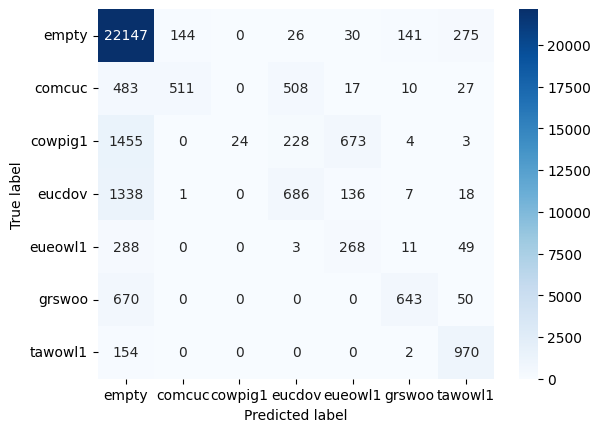

Estimated performance:
Accuracy: 0.735083 Avg loss: 59.096371 

              precision    recall  f1-score   support

       empty       0.81      0.92      0.86     17073
      comcuc       0.10      0.10      0.10      1166
     cowpig1       0.50      0.00      0.00      1790
      eucdov       0.40      0.30      0.34      1640
     eueowl1       0.33      0.52      0.41       465
      grswoo       0.83      0.39      0.53      1022
     tawowl1       0.71      0.81      0.76       844

    accuracy                           0.74     24000
   macro avg       0.53      0.43      0.43     24000
weighted avg       0.71      0.74      0.70     24000



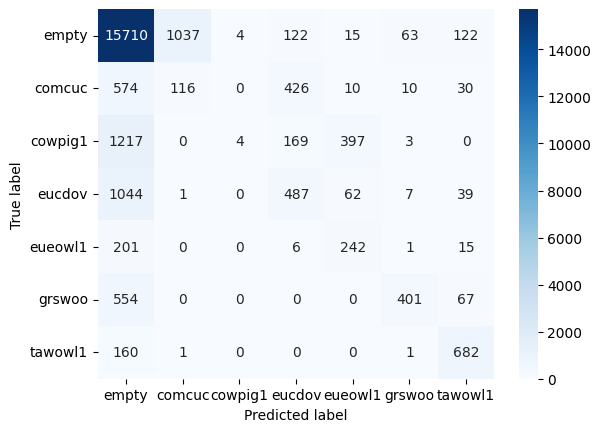

Fold 2
Accuracy: 0.816531 Avg loss: 0.575732 

              precision    recall  f1-score   support

       empty       0.86      0.97      0.91     22760
      comcuc       0.95      0.43      0.59      1556
     cowpig1       1.00      0.01      0.03      2389
      eucdov       0.70      0.63      0.66      2186
     eueowl1       0.28      0.59      0.38       620
      grswoo       0.81      0.53      0.64      1363
     tawowl1       0.64      0.73      0.68      1126

    accuracy                           0.82     32000
   macro avg       0.75      0.56      0.56     32000
weighted avg       0.84      0.82      0.78     32000



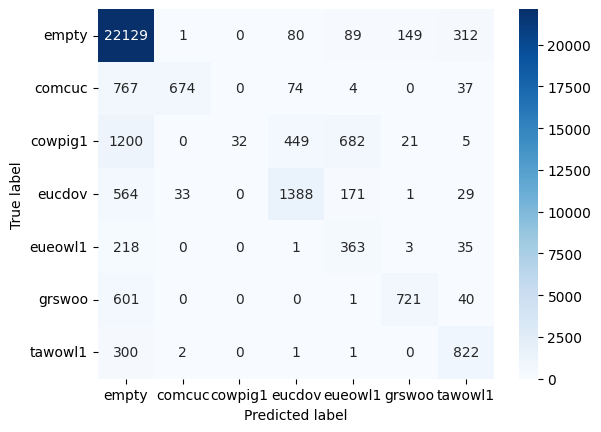

Estimated performance:
Accuracy: 0.809000 Avg loss: 48.228088 

              precision    recall  f1-score   support

       empty       0.87      0.98      0.92     17073
      comcuc       0.81      0.24      0.37      1166
     cowpig1       0.82      0.01      0.01      1790
      eucdov       0.50      0.57      0.53      1640
     eueowl1       0.31      0.62      0.41       465
      grswoo       0.84      0.36      0.51      1022
     tawowl1       0.66      0.87      0.75       844

    accuracy                           0.81     24000
   macro avg       0.69      0.52      0.50     24000
weighted avg       0.82      0.81      0.77     24000



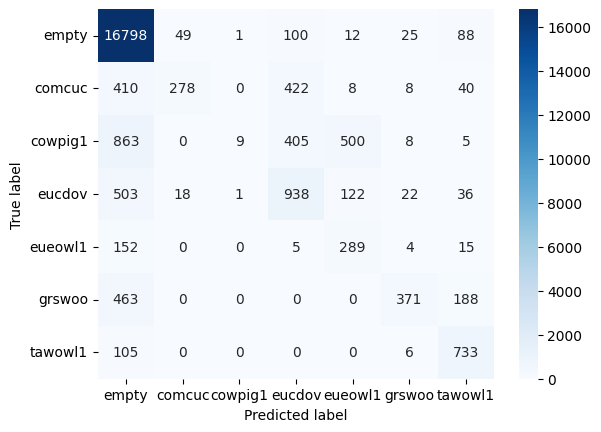

Fold 3
Accuracy: 0.658563 Avg loss: 1.152559 

              precision    recall  f1-score   support

       empty       0.89      0.73      0.80     22762
      comcuc       0.95      0.38      0.55      1555
     cowpig1       0.83      0.01      0.02      2388
      eucdov       0.65      0.51      0.57      2186
     eueowl1       0.21      0.70      0.32       620
      grswoo       0.50      0.84      0.63      1363
     tawowl1       0.17      0.98      0.29      1126

    accuracy                           0.66     32000
   macro avg       0.60      0.59      0.45     32000
weighted avg       0.82      0.66      0.68     32000



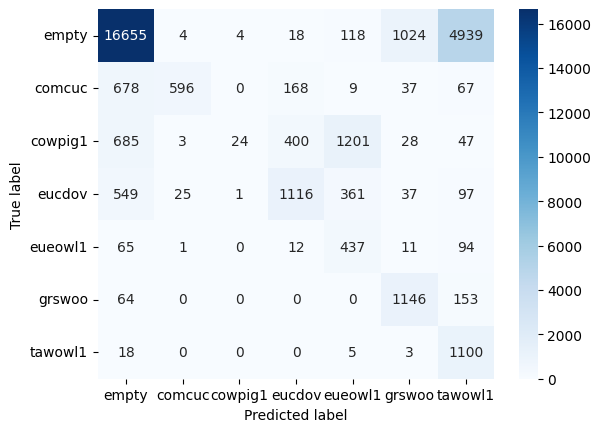

Estimated performance:
Accuracy: 0.773292 Avg loss: 43.729073 

              precision    recall  f1-score   support

       empty       0.92      0.90      0.91     17073
      comcuc       0.85      0.27      0.41      1166
     cowpig1       0.57      0.01      0.01      1790
      eucdov       0.50      0.55      0.52      1640
     eueowl1       0.26      0.78      0.39       465
      grswoo       0.53      0.70      0.60      1022
     tawowl1       0.36      0.97      0.53       844

    accuracy                           0.77     24000
   macro avg       0.57      0.60      0.48     24000
weighted avg       0.81      0.77      0.76     24000



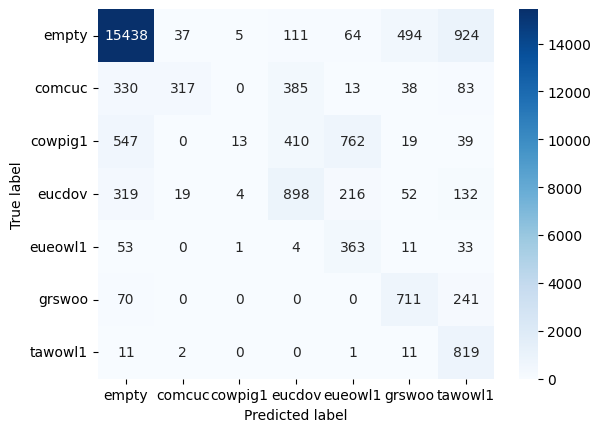

In [52]:
#Training on entire dataset leads to massive bias towards empty class
model = lambda _: nn.Sequential(
        nn.Linear(548, 256),
        nn.ReLU(),
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Linear(256, 7)
    )

eval(model, X_train, y_train, ['empty', 'comcuc', 'cowpig1', 'eucdov', 'eueowl1', 'grswoo', 'tawowl1'], stratify_criterion, 10, False, X_test, y_test)

In [62]:
X_train_no_empty = X_train[y_train != 0]
stratify_criterion_no_empty = stratify_criterion[y_train != 0]
y_train_no_empty = y_train[y_train != 0]
y_train_no_empty -= 1

X_test_no_empty = X_test[y_test != 0]
y_test_no_empty = y_test[y_test != 0]
y_test_no_empty -= 1

print(X_train_no_empty.shape, y_train_no_empty.shape, stratify_criterion_no_empty.shape, X_test_no_empty.shape, y_test_no_empty.shape)

_, counts = np.unique(y_test_no_empty, return_counts=True)
print(counts/np.sum(counts)*100)

(27715, 548) (27715,) (27715,) (6927, 548) (6927,)
[16.8326837  25.84091237 23.67547279  6.71286271 14.7538617  12.18420673]


Fold 1
Accuracy: 0.637190 Avg loss: 1.094429 

              precision    recall  f1-score   support

      comcuc       0.99      0.72      0.83      1556
     cowpig1       0.95      0.13      0.23      2388
      eucdov       0.55      0.77      0.64      2186
     eueowl1       0.26      0.77      0.39       620
      grswoo       0.88      0.91      0.90      1363
     tawowl1       0.73      0.94      0.82      1126

    accuracy                           0.64      9239
   macro avg       0.73      0.71      0.63      9239
weighted avg       0.78      0.64      0.61      9239



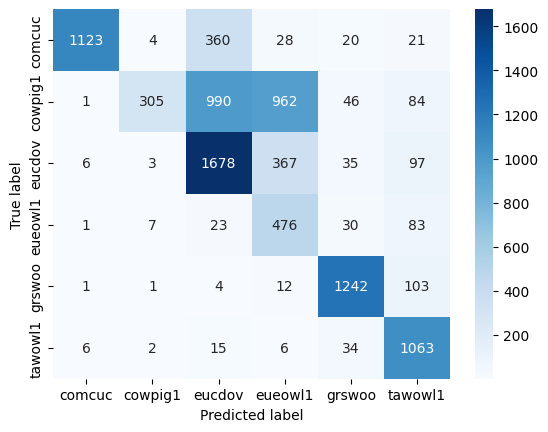

Fold 2
Accuracy: 0.687486 Avg loss: 0.889236 

              precision    recall  f1-score   support

      comcuc       0.97      0.94      0.96      1556
     cowpig1       0.99      0.18      0.31      2388
      eucdov       0.66      0.74      0.70      2186
     eueowl1       0.25      0.77      0.38       619
      grswoo       0.93      0.92      0.92      1363
     tawowl1       0.70      0.97      0.82      1126

    accuracy                           0.69      9238
   macro avg       0.75      0.76      0.68      9238
weighted avg       0.81      0.69      0.67      9238



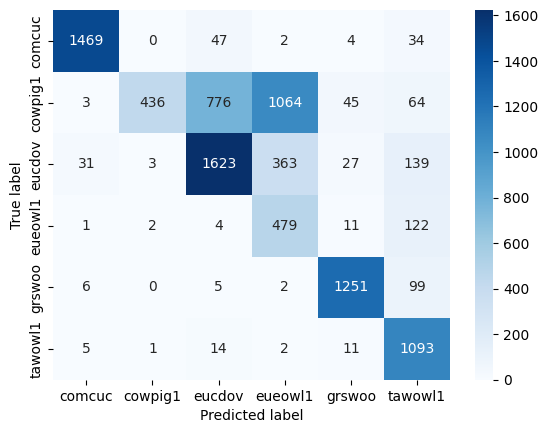

Fold 3
Accuracy: 0.662481 Avg loss: 1.072603 

              precision    recall  f1-score   support

      comcuc       0.98      0.88      0.93      1555
     cowpig1       0.96      0.14      0.25      2388
      eucdov       0.63      0.73      0.68      2186
     eueowl1       0.24      0.79      0.37       620
      grswoo       0.92      0.90      0.91      1363
     tawowl1       0.69      0.98      0.81      1126

    accuracy                           0.66      9238
   macro avg       0.74      0.74      0.66      9238
weighted avg       0.80      0.66      0.64      9238



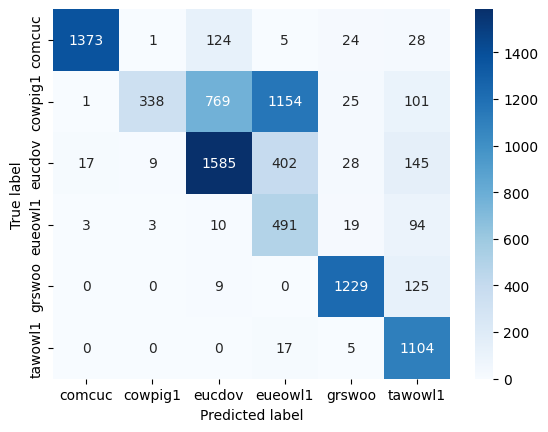

Fold 1
Accuracy: 0.603420 Avg loss: 1.476625 

              precision    recall  f1-score   support

      comcuc       0.97      0.74      0.84      1556
     cowpig1       0.91      0.15      0.26      2388
      eucdov       0.56      0.59      0.58      2186
     eueowl1       0.20      0.80      0.33       620
      grswoo       0.86      0.88      0.87      1363
     tawowl1       0.69      0.96      0.80      1126

    accuracy                           0.60      9239
   macro avg       0.70      0.69      0.61      9239
weighted avg       0.76      0.60      0.59      9239



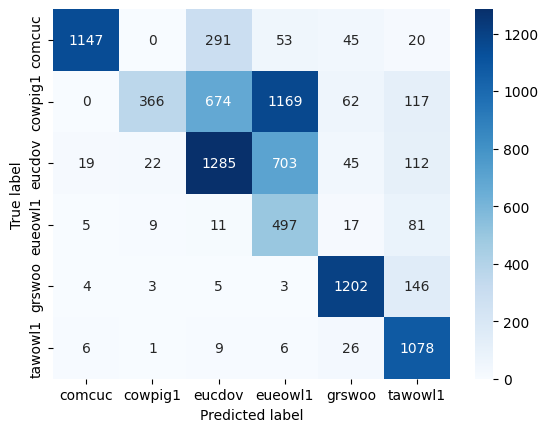

Fold 2
Accuracy: 0.638017 Avg loss: 1.260210 

              precision    recall  f1-score   support

      comcuc       0.94      0.92      0.93      1556
     cowpig1       0.81      0.17      0.28      2388
      eucdov       0.61      0.68      0.64      2186
     eueowl1       0.24      0.65      0.35       619
      grswoo       0.85      0.77      0.81      1363
     tawowl1       0.60      0.98      0.75      1126

    accuracy                           0.64      9238
   macro avg       0.67      0.70      0.63      9238
weighted avg       0.73      0.64      0.62      9238



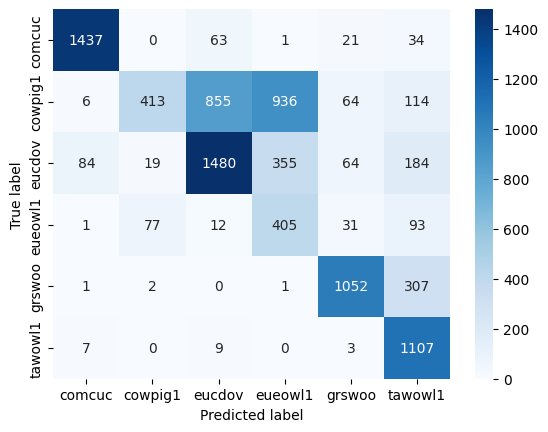

Fold 3
Accuracy: 0.607058 Avg loss: 1.648188 

              precision    recall  f1-score   support

      comcuc       0.97      0.83      0.90      1555
     cowpig1       0.75      0.11      0.20      2388
      eucdov       0.63      0.67      0.65      2186
     eueowl1       0.19      0.67      0.30       620
      grswoo       0.90      0.77      0.83      1363
     tawowl1       0.60      0.99      0.75      1126

    accuracy                           0.61      9238
   macro avg       0.67      0.67      0.60      9238
weighted avg       0.72      0.61      0.59      9238



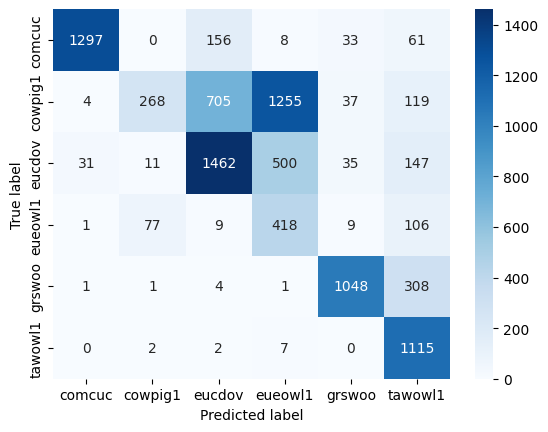

In [20]:
#Maybe NN is only useful for difference between birds
model = lambda _: nn.Sequential(
        nn.Linear(548, 256),
        nn.ReLU(),
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Linear(256, 6)
    )
eval(model, X_train_no_empty, y_train_no_empty, ['comcuc', 'cowpig1', 'eucdov', 'eueowl1', 'grswoo', 'tawowl1'], stratify_criterion_no_empty, 15, False, X_test_no_empty, y_test_no_empty)

model = lambda _: nn.Sequential(
        nn.Linear(548, 512),
        nn.ReLU(),
        nn.Linear(512, 512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Linear(256, 6)
    )
eval(model, X_train_no_empty, y_train_no_empty, ['comcuc', 'cowpig1', 'eucdov', 'eueowl1', 'grswoo', 'tawowl1'], stratify_criterion_no_empty, 25, False)

In [21]:
X_train_binary = X_train
y_train_binary = np.copy(y_train)
y_train_binary[y_train_binary != 0] = 1

X_test_binary = X_test
y_test_binary = np.copy(y_test)
y_test_binary[y_test_binary != 0] = 1

print(X_train_binary.shape, y_train_binary.shape, X_test_binary.shape, y_test_binary.shape)

(96000, 548) (96000,) (24000, 548) (24000,)


Fold 1
Accuracy: 0.797219 Avg loss: 0.585828 

              precision    recall  f1-score   support

       empty       0.88      0.83      0.85     22761
        bird       0.63      0.71      0.67      9239

    accuracy                           0.80     32000
   macro avg       0.75      0.77      0.76     32000
weighted avg       0.81      0.80      0.80     32000



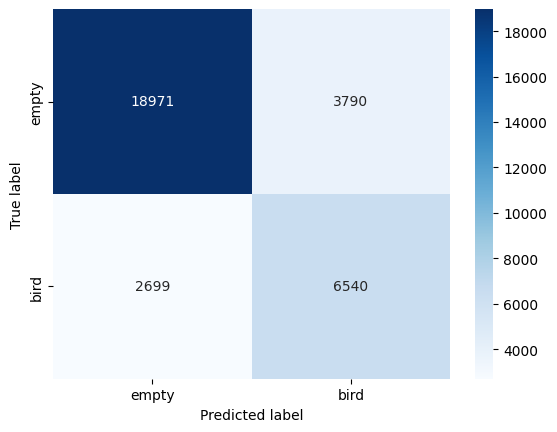

Fold 2
Accuracy: 0.847344 Avg loss: 0.432183 

              precision    recall  f1-score   support

       empty       0.86      0.94      0.90     22762
        bird       0.81      0.62      0.70      9238

    accuracy                           0.85     32000
   macro avg       0.83      0.78      0.80     32000
weighted avg       0.84      0.85      0.84     32000



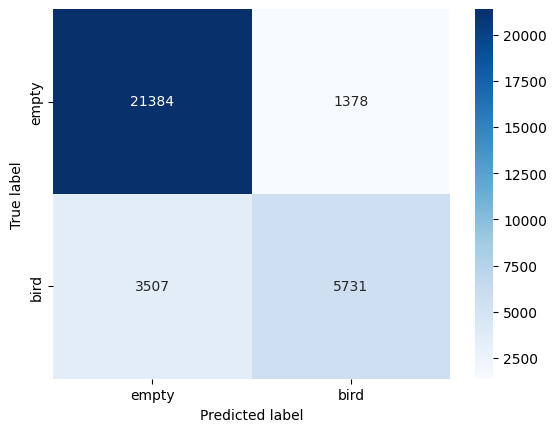

Fold 3
Accuracy: 0.732969 Avg loss: 2.380896 

              precision    recall  f1-score   support

       empty       0.73      1.00      0.84     22762
        bird       0.91      0.08      0.15      9238

    accuracy                           0.73     32000
   macro avg       0.82      0.54      0.50     32000
weighted avg       0.78      0.73      0.64     32000



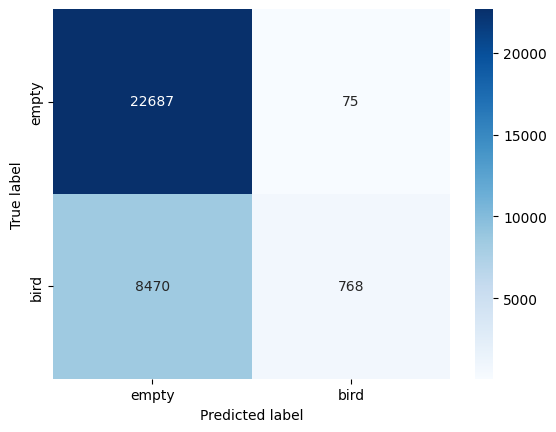

In [22]:
model = lambda _: nn.Sequential(
        nn.Linear(548, 256),
        nn.ReLU(),
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Linear(256, 2)
    )
eval(model, X_train_binary, y_train_binary, ['empty', 'bird'], y_train_binary, 15, False)

In [23]:
indices = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 18, 19, 21, 22, 24,
 26, 31, 32, 34, 41, 45, 46, 47, 62, 69, 73, 75, 78, 88, 99, 117, 145, 151,
 159, 174, 175, 182, 187, 197, 201, 219, 221, 224, 225, 226, 230, 231, 239, 246, 
 247, 249, 256, 257, 259, 260, 261, 262, 266, 272, 277, 285, 287, 291, 297, 302, 
 304, 319, 320, 321, 325, 327, 332, 335, 340, 347, 350, 351, 354, 366, 369, 370, 
 371, 380, 384, 387, 388, 396, 398, 399, 400, 401, 402, 405, 407, 409, 411, 412, 
 413, 415, 416, 417, 418, 419, 420, 421, 422, 424, 430, 433, 436, 440, 443, 451, 
 453, 454, 457, 463, 467, 469, 472, 478, 479, 487, 488, 490, 491, 494, 501, 505, 
 507, 539])

print(indices.shape)

(134,)


Fold 1
Accuracy: 0.800937 Avg loss: 0.759553 

              precision    recall  f1-score   support

       empty       0.85      0.96      0.90     22763
      comcuc       0.75      0.52      0.62      1556
     cowpig1       0.97      0.05      0.09      2387
      eucdov       0.52      0.39      0.45      2186
     eueowl1       0.28      0.42      0.34       619
      grswoo       0.76      0.53      0.62      1363
     tawowl1       0.70      0.83      0.76      1126

    accuracy                           0.80     32000
   macro avg       0.69      0.53      0.54     32000
weighted avg       0.81      0.80      0.77     32000



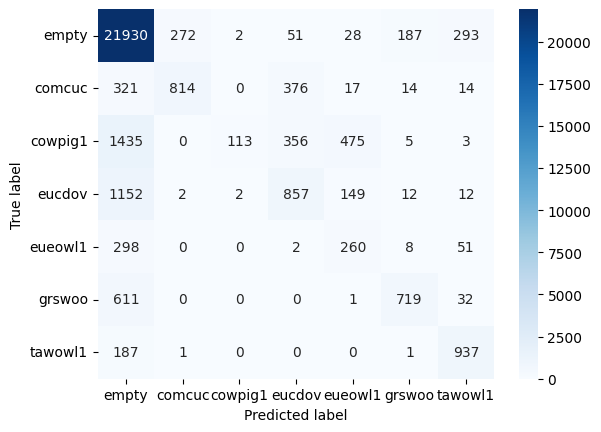

Estimated performance:
Accuracy: 0.665292 Avg loss: 1.202422 

              precision    recall  f1-score   support

       empty       0.80      0.81      0.81     17073
      comcuc       0.08      0.19      0.11      1166
     cowpig1       0.59      0.01      0.03      1790
      eucdov       0.40      0.36      0.38      1640
     eueowl1       0.34      0.46      0.39       465
      grswoo       0.69      0.37      0.48      1022
     tawowl1       0.59      0.78      0.67       844

    accuracy                           0.67     24000
   macro avg       0.50      0.43      0.41     24000
weighted avg       0.70      0.67      0.66     24000



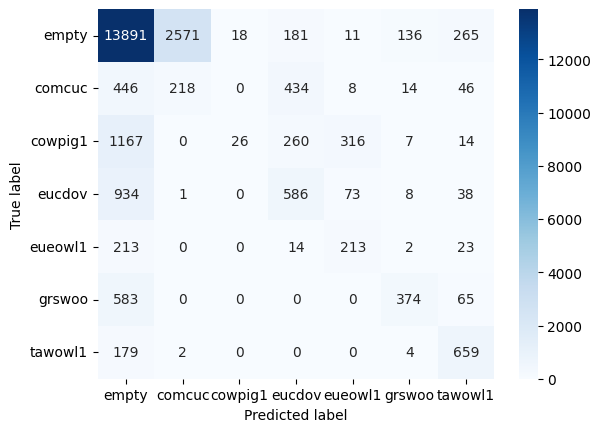

Fold 2
Accuracy: 0.822937 Avg loss: 0.595113 

              precision    recall  f1-score   support

       empty       0.86      0.97      0.91     22760
      comcuc       0.97      0.63      0.77      1556
     cowpig1       0.99      0.04      0.08      2389
      eucdov       0.66      0.54      0.59      2186
     eueowl1       0.29      0.55      0.38       620
      grswoo       0.72      0.64      0.68      1363
     tawowl1       0.68      0.71      0.70      1126

    accuracy                           0.82     32000
   macro avg       0.74      0.58      0.59     32000
weighted avg       0.84      0.82      0.79     32000



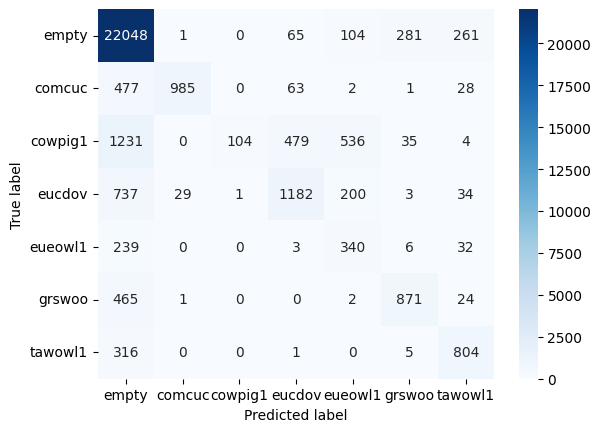

Estimated performance:
Accuracy: 0.807625 Avg loss: 0.693680 

              precision    recall  f1-score   support

       empty       0.87      0.97      0.92     17073
      comcuc       0.64      0.34      0.44      1166
     cowpig1       0.82      0.02      0.04      1790
      eucdov       0.48      0.51      0.50      1640
     eueowl1       0.32      0.62      0.43       465
      grswoo       0.85      0.52      0.65      1022
     tawowl1       0.69      0.86      0.76       844

    accuracy                           0.81     24000
   macro avg       0.67      0.55      0.53     24000
weighted avg       0.81      0.81      0.77     24000



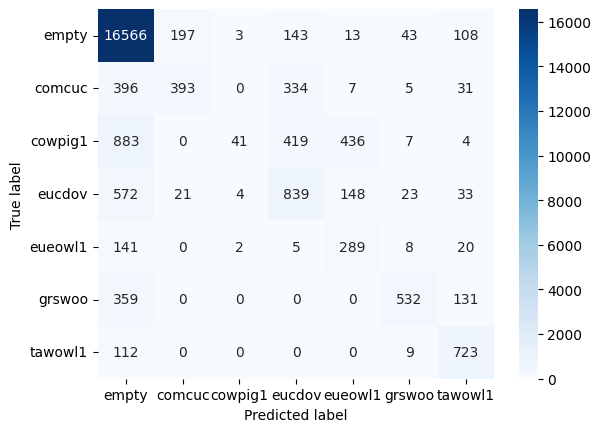

Fold 3
Accuracy: 0.601750 Avg loss: 1.312766 

              precision    recall  f1-score   support

       empty       0.90      0.64      0.75     22762
      comcuc       0.96      0.53      0.68      1555
     cowpig1       0.67      0.06      0.11      2388
      eucdov       0.58      0.44      0.50      2186
     eueowl1       0.19      0.67      0.29       620
      grswoo       0.43      0.88      0.58      1363
     tawowl1       0.14      0.98      0.24      1126

    accuracy                           0.60     32000
   macro avg       0.55      0.60      0.45     32000
weighted avg       0.80      0.60      0.65     32000



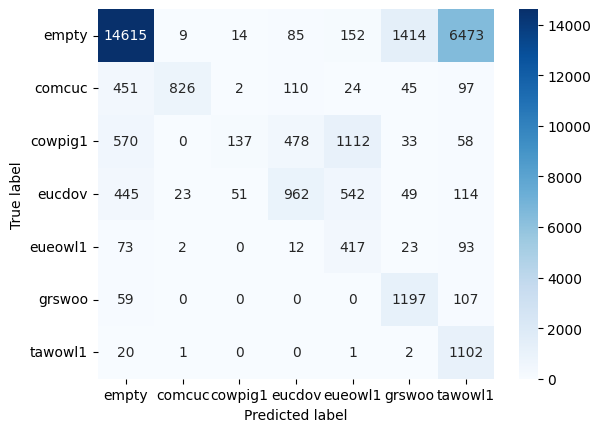

Estimated performance:
Accuracy: 0.750875 Avg loss: 0.780290 

              precision    recall  f1-score   support

       empty       0.93      0.86      0.90     17073
      comcuc       0.73      0.37      0.49      1166
     cowpig1       0.67      0.05      0.09      1790
      eucdov       0.49      0.53      0.51      1640
     eueowl1       0.23      0.78      0.35       465
      grswoo       0.46      0.71      0.56      1022
     tawowl1       0.32      0.96      0.48       844

    accuracy                           0.75     24000
   macro avg       0.55      0.61      0.48     24000
weighted avg       0.82      0.75      0.75     24000



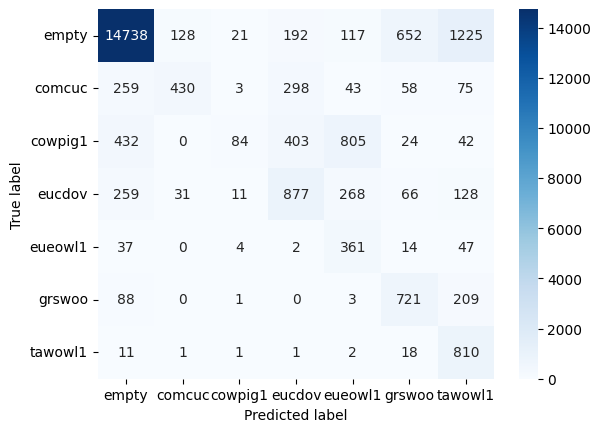

In [54]:

#Training on entire dataset leads to massive bias towards empty class
model = lambda _: nn.Sequential(
        nn.Linear(134, 128),
        nn.ReLU(),
        nn.Linear(128, 128),
        nn.ReLU(),
        nn.Linear(128, 7)
    )

eval(model, X_train[:, indices], y_train, ['empty', 'comcuc', 'cowpig1', 'eucdov', 'eueowl1', 'grswoo', 'tawowl1'], stratify_criterion, 30, False, X_test[:, indices], y_test)

Fold 1
Accuracy: 0.685139 Avg loss: 1.150371 

              precision    recall  f1-score   support

      comcuc       0.98      0.77      0.86      1556
     cowpig1       0.90      0.26      0.41      2388
      eucdov       0.56      0.80      0.66      2186
     eueowl1       0.32      0.76      0.45       620
      grswoo       0.87      0.91      0.89      1363
     tawowl1       0.78      0.93      0.85      1126

    accuracy                           0.69      9239
   macro avg       0.74      0.74      0.69      9239
weighted avg       0.78      0.69      0.67      9239



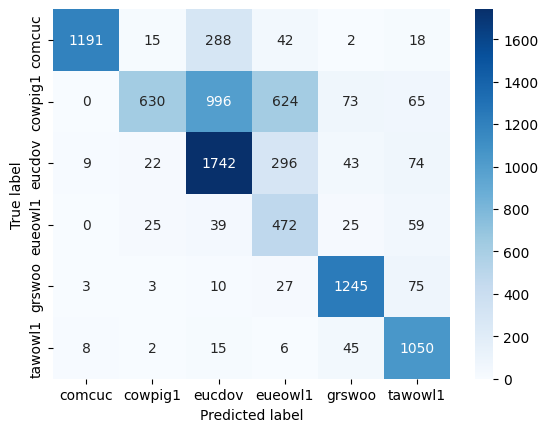

Estimated performance:
Accuracy: 0.569655 Avg loss: 1.804005 

              precision    recall  f1-score   support

      comcuc       0.94      0.42      0.58      1166
     cowpig1       0.77      0.16      0.26      1790
      eucdov       0.46      0.74      0.57      1640
     eueowl1       0.31      0.84      0.46       465
      grswoo       0.82      0.78      0.80      1022
     tawowl1       0.64      0.92      0.75       844

    accuracy                           0.57      6927
   macro avg       0.66      0.64      0.57      6927
weighted avg       0.69      0.57      0.54      6927



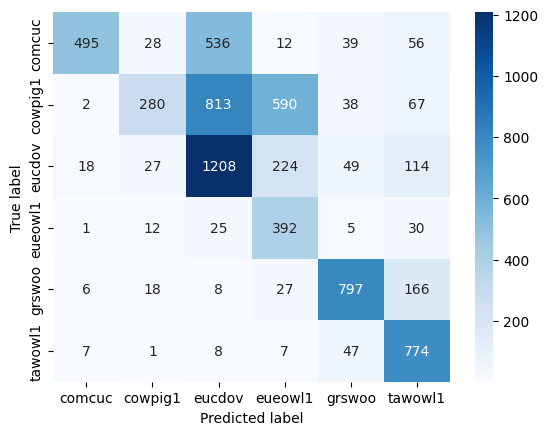

Fold 2
Accuracy: 0.697987 Avg loss: 1.048246 

              precision    recall  f1-score   support

      comcuc       0.97      0.95      0.96      1556
     cowpig1       0.93      0.21      0.34      2388
      eucdov       0.61      0.76      0.67      2186
     eueowl1       0.30      0.81      0.44       619
      grswoo       0.90      0.93      0.92      1363
     tawowl1       0.78      0.94      0.85      1126

    accuracy                           0.70      9238
   macro avg       0.75      0.77      0.69      9238
weighted avg       0.79      0.70      0.68      9238



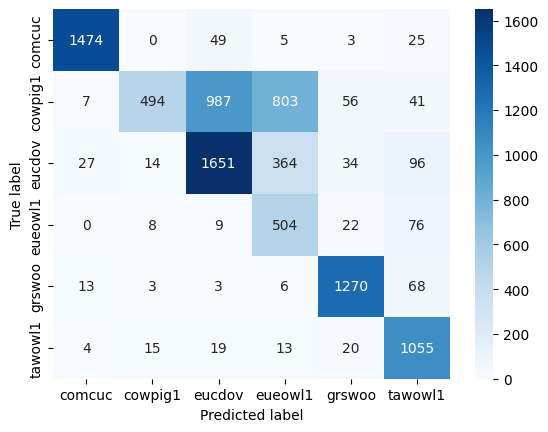

Estimated performance:
Accuracy: 0.593475 Avg loss: 1.522366 

              precision    recall  f1-score   support

      comcuc       0.93      0.56      0.70      1166
     cowpig1       0.76      0.15      0.25      1790
      eucdov       0.52      0.75      0.61      1640
     eueowl1       0.29      0.86      0.43       465
      grswoo       0.85      0.74      0.79      1022
     tawowl1       0.66      0.94      0.78       844

    accuracy                           0.59      6927
   macro avg       0.67      0.67      0.59      6927
weighted avg       0.70      0.59      0.57      6927



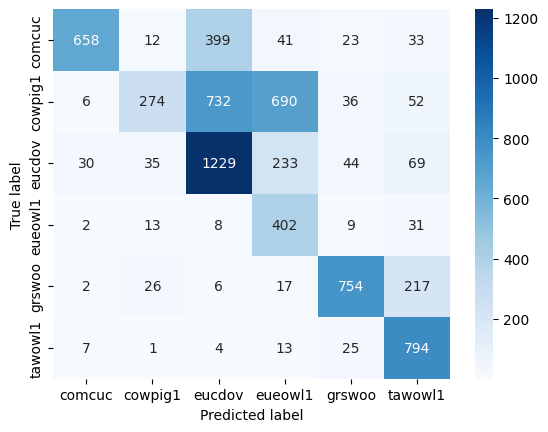

Fold 3
Accuracy: 0.657935 Avg loss: 1.364516 

              precision    recall  f1-score   support

      comcuc       0.97      0.88      0.93      1555
     cowpig1       0.89      0.13      0.23      2388
      eucdov       0.58      0.70      0.63      2186
     eueowl1       0.26      0.81      0.39       620
      grswoo       0.92      0.92      0.92      1363
     tawowl1       0.74      0.98      0.84      1126

    accuracy                           0.66      9238
   macro avg       0.73      0.74      0.66      9238
weighted avg       0.77      0.66      0.63      9238



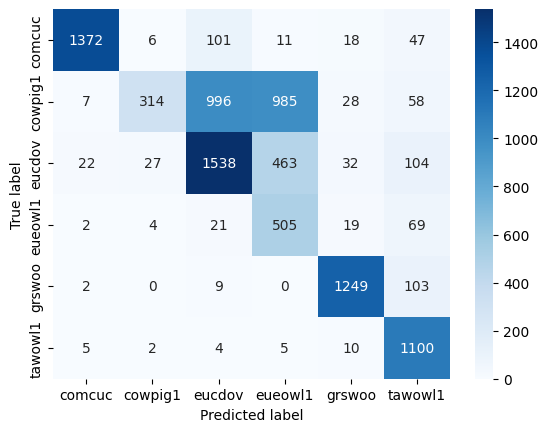

Estimated performance:
Accuracy: 0.591887 Avg loss: 1.609486 

              precision    recall  f1-score   support

      comcuc       0.92      0.51      0.65      1166
     cowpig1       0.83      0.16      0.27      1790
      eucdov       0.51      0.76      0.61      1640
     eueowl1       0.31      0.86      0.46       465
      grswoo       0.85      0.78      0.81      1022
     tawowl1       0.60      0.93      0.73       844

    accuracy                           0.59      6927
   macro avg       0.67      0.67      0.59      6927
weighted avg       0.71      0.59      0.56      6927



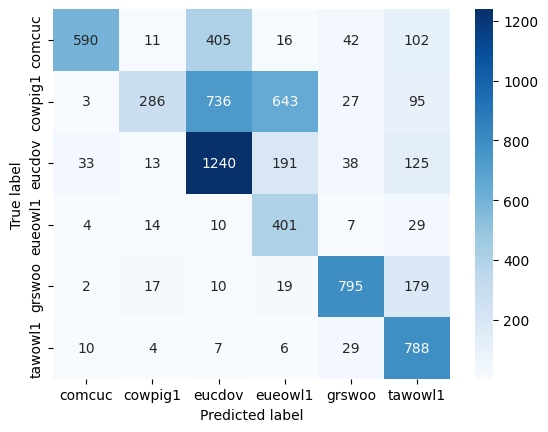

Fold 1
Accuracy: 0.813183 Avg loss: 1.652039 

              precision    recall  f1-score   support

      comcuc       0.95      0.83      0.89      1556
     cowpig1       0.84      0.68      0.75      2388
      eucdov       0.68      0.88      0.77      2186
     eueowl1       0.64      0.70      0.66       620
      grswoo       0.91      0.92      0.91      1363
     tawowl1       0.92      0.89      0.90      1126

    accuracy                           0.81      9239
   macro avg       0.82      0.81      0.81      9239
weighted avg       0.83      0.81      0.81      9239



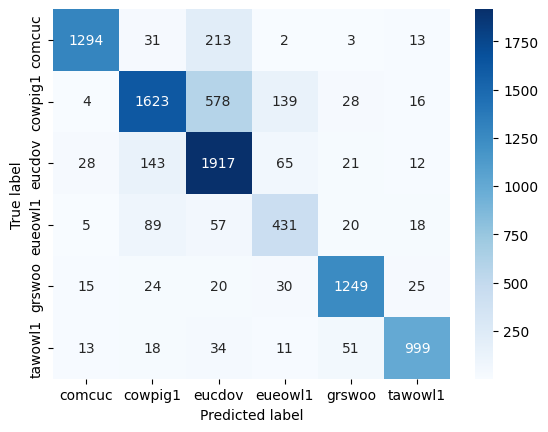

Estimated performance:
Accuracy: 0.686011 Avg loss: 3.212295 

              precision    recall  f1-score   support

      comcuc       0.88      0.50      0.64      1166
     cowpig1       0.72      0.54      0.61      1790
      eucdov       0.55      0.81      0.65      1640
     eueowl1       0.49      0.71      0.58       465
      grswoo       0.86      0.80      0.83      1022
     tawowl1       0.82      0.87      0.84       844

    accuracy                           0.69      6927
   macro avg       0.72      0.71      0.69      6927
weighted avg       0.72      0.69      0.69      6927



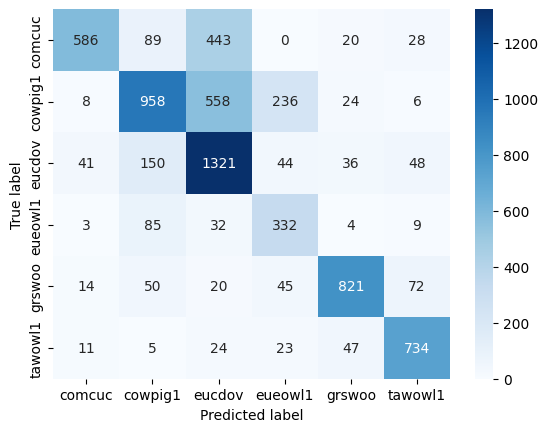

Fold 2
Accuracy: 0.849751 Avg loss: 1.147531 

              precision    recall  f1-score   support

      comcuc       0.89      0.99      0.94      1556
     cowpig1       0.90      0.68      0.77      2388
      eucdov       0.75      0.89      0.81      2186
     eueowl1       0.72      0.82      0.77       619
      grswoo       0.95      0.93      0.94      1363
     tawowl1       0.92      0.86      0.89      1126

    accuracy                           0.85      9238
   macro avg       0.85      0.86      0.85      9238
weighted avg       0.86      0.85      0.85      9238



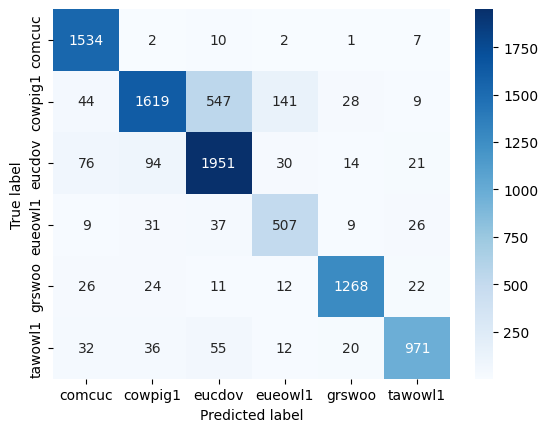

Estimated performance:
Accuracy: 0.711275 Avg loss: 2.874083 

              precision    recall  f1-score   support

      comcuc       0.86      0.64      0.73      1166
     cowpig1       0.73      0.51      0.60      1790
      eucdov       0.58      0.82      0.68      1640
     eueowl1       0.55      0.76      0.64       465
      grswoo       0.90      0.79      0.84      1022
     tawowl1       0.81      0.90      0.85       844

    accuracy                           0.71      6927
   macro avg       0.74      0.74      0.72      6927
weighted avg       0.74      0.71      0.71      6927



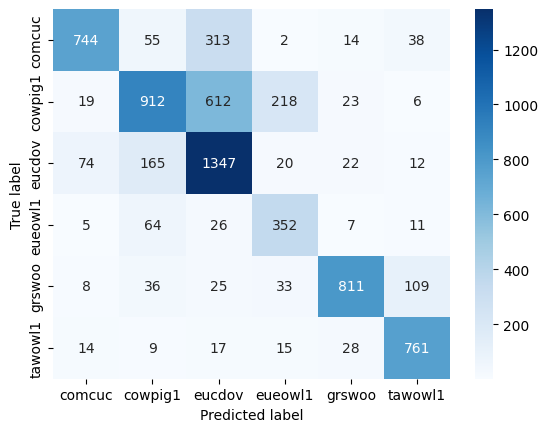

Fold 3
Accuracy: 0.771054 Avg loss: 1.811911 

              precision    recall  f1-score   support

      comcuc       0.93      0.90      0.92      1555
     cowpig1       0.78      0.52      0.63      2388
      eucdov       0.65      0.77      0.70      2186
     eueowl1       0.49      0.77      0.60       620
      grswoo       0.92      0.94      0.93      1363
     tawowl1       0.87      0.92      0.89      1126

    accuracy                           0.77      9238
   macro avg       0.77      0.80      0.78      9238
weighted avg       0.79      0.77      0.77      9238



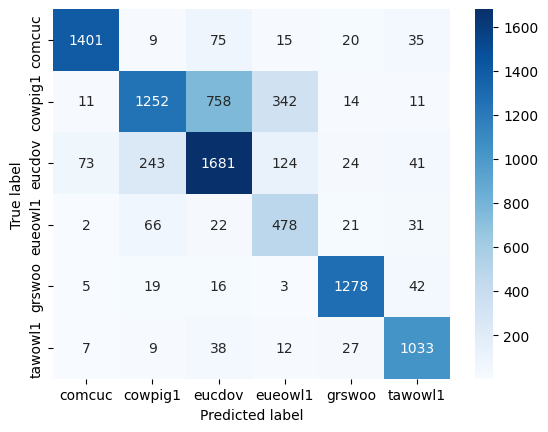

Estimated performance:
Accuracy: 0.709109 Avg loss: 2.739052 

              precision    recall  f1-score   support

      comcuc       0.89      0.56      0.68      1166
     cowpig1       0.73      0.54      0.62      1790
      eucdov       0.58      0.80      0.67      1640
     eueowl1       0.55      0.83      0.66       465
      grswoo       0.88      0.83      0.86      1022
     tawowl1       0.80      0.88      0.84       844

    accuracy                           0.71      6927
   macro avg       0.74      0.74      0.72      6927
weighted avg       0.74      0.71      0.71      6927



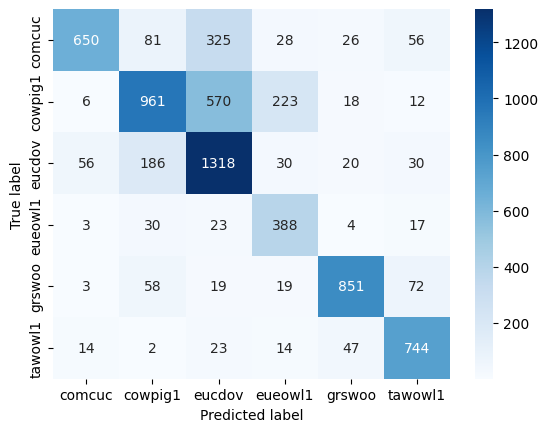

In [58]:
#Maybe NN is only useful for difference between birds
model = lambda _: nn.Sequential(
        nn.Linear(134, 128),
        nn.ReLU(),
        nn.Linear(128, 128),
        nn.ReLU(),
        nn.Linear(128, 6)
    )

eval(model, X_train_no_empty[:, indices], y_train_no_empty, ['comcuc', 'cowpig1', 'eucdov', 'eueowl1', 'grswoo', 'tawowl1'], stratify_criterion_no_empty, 50, False, X_test_no_empty[:, indices], y_test_no_empty)
eval(model, X_train_no_empty[:, indices], y_train_no_empty, ['comcuc', 'cowpig1', 'eucdov', 'eueowl1', 'grswoo', 'tawowl1'], stratify_criterion_no_empty, 400, False, X_test_no_empty[:, indices], y_test_no_empty)

Fold 1
Accuracy: 0.809503 Avg loss: 3.303248 

              precision    recall  f1-score   support

      comcuc       0.97      0.80      0.88      1556
     cowpig1       0.78      0.80      0.79      2388
      eucdov       0.71      0.77      0.74      2186
     eueowl1       0.64      0.69      0.67       620
      grswoo       0.89      0.91      0.90      1363
     tawowl1       0.90      0.87      0.89      1126

    accuracy                           0.81      9239
   macro avg       0.82      0.81      0.81      9239
weighted avg       0.82      0.81      0.81      9239



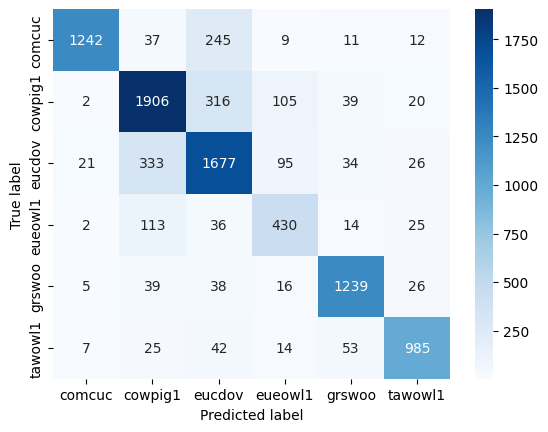

Estimated performance:
Accuracy: 0.681536 Avg loss: 5.557517 

              precision    recall  f1-score   support

      comcuc       0.88      0.50      0.64      1166
     cowpig1       0.68      0.67      0.68      1790
      eucdov       0.56      0.70      0.62      1640
     eueowl1       0.55      0.66      0.60       465
      grswoo       0.82      0.74      0.78      1022
     tawowl1       0.75      0.85      0.80       844

    accuracy                           0.68      6927
   macro avg       0.71      0.69      0.69      6927
weighted avg       0.71      0.68      0.68      6927



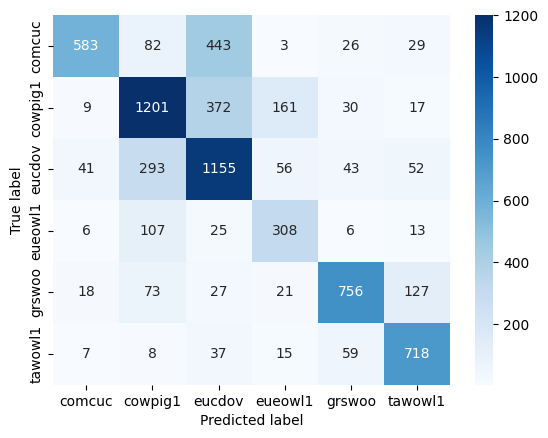

Fold 2
Accuracy: 0.852024 Avg loss: 2.243517 

              precision    recall  f1-score   support

      comcuc       0.91      0.97      0.94      1556
     cowpig1       0.84      0.78      0.81      2388
      eucdov       0.78      0.84      0.81      2186
     eueowl1       0.73      0.76      0.75       619
      grswoo       0.93      0.90      0.92      1363
     tawowl1       0.91      0.84      0.87      1126

    accuracy                           0.85      9238
   macro avg       0.85      0.85      0.85      9238
weighted avg       0.85      0.85      0.85      9238



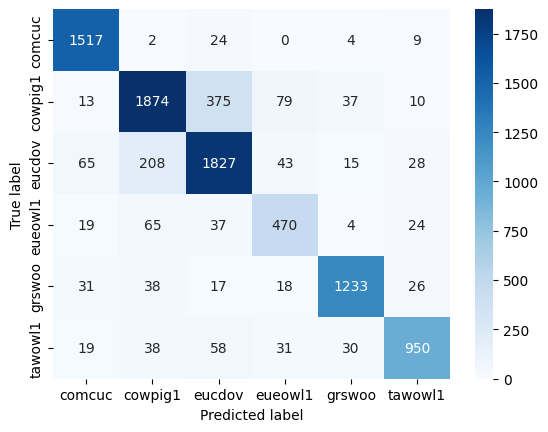

Estimated performance:
Accuracy: 0.715606 Avg loss: 5.498233 

              precision    recall  f1-score   support

      comcuc       0.85      0.63      0.72      1166
     cowpig1       0.72      0.63      0.67      1790
      eucdov       0.62      0.78      0.69      1640
     eueowl1       0.55      0.71      0.62       465
      grswoo       0.85      0.73      0.78      1022
     tawowl1       0.79      0.89      0.84       844

    accuracy                           0.72      6927
   macro avg       0.73      0.73      0.72      6927
weighted avg       0.73      0.72      0.72      6927



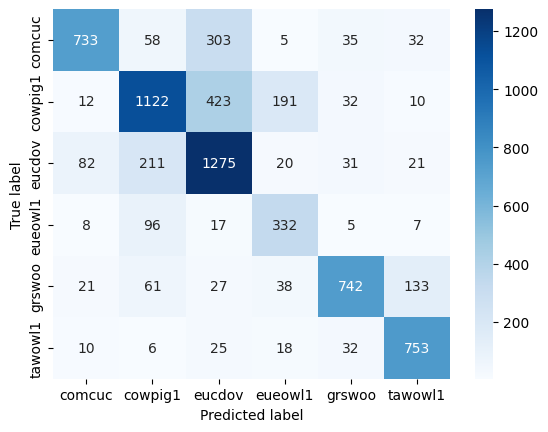

Fold 3
Accuracy: 0.792271 Avg loss: 3.150393 

              precision    recall  f1-score   support

      comcuc       0.95      0.89      0.92      1555
     cowpig1       0.74      0.68      0.71      2388
      eucdov       0.70      0.72      0.71      2186
     eueowl1       0.59      0.74      0.66       620
      grswoo       0.90      0.93      0.92      1363
     tawowl1       0.87      0.90      0.89      1126

    accuracy                           0.79      9238
   macro avg       0.79      0.81      0.80      9238
weighted avg       0.80      0.79      0.79      9238



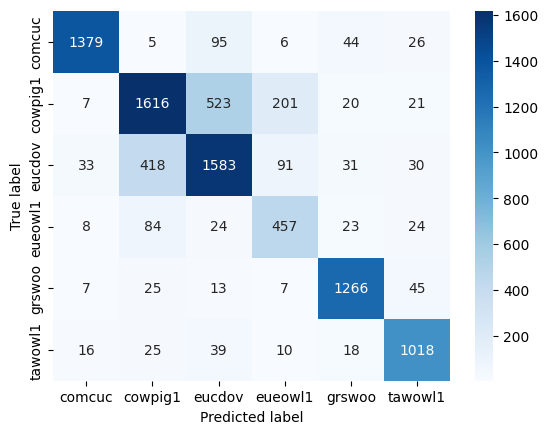

Estimated performance:
Accuracy: 0.698715 Avg loss: 5.603006 

              precision    recall  f1-score   support

      comcuc       0.84      0.49      0.62      1166
     cowpig1       0.71      0.66      0.68      1790
      eucdov       0.59      0.75      0.66      1640
     eueowl1       0.58      0.72      0.64       465
      grswoo       0.86      0.79      0.82      1022
     tawowl1       0.74      0.83      0.78       844

    accuracy                           0.70      6927
   macro avg       0.72      0.71      0.70      6927
weighted avg       0.72      0.70      0.70      6927



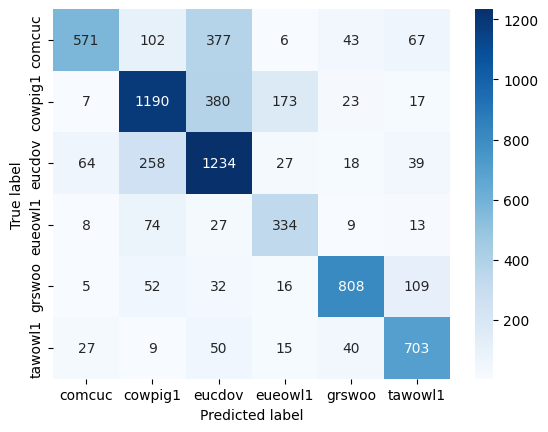

In [59]:
model = lambda _: nn.Sequential(
        nn.Linear(134, 128),
        nn.ReLU(),
        nn.Linear(128, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 128),
        nn.ReLU(),
        nn.Linear(128, 6)
    )

eval(model, X_train_no_empty[:, indices], y_train_no_empty, ['comcuc', 'cowpig1', 'eucdov', 'eueowl1', 'grswoo', 'tawowl1'], stratify_criterion_no_empty, 500, False, X_test_no_empty[:, indices], y_test_no_empty)

Fold 1
Accuracy: 0.791000 Avg loss: 1.110402 

              precision    recall  f1-score   support

       empty       0.85      0.85      0.85     22761
        bird       0.64      0.64      0.64      9239

    accuracy                           0.79     32000
   macro avg       0.75      0.74      0.75     32000
weighted avg       0.79      0.79      0.79     32000



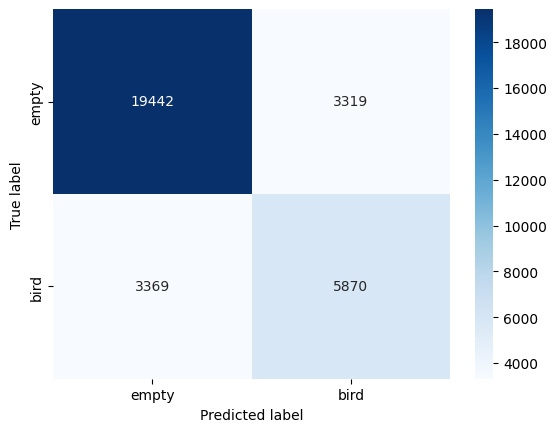

Estimated performance:
Accuracy: 0.782292 Avg loss: 1.088306 

              precision    recall  f1-score   support

       empty       0.86      0.83      0.84     17073
        bird       0.61      0.66      0.64      6927

    accuracy                           0.78     24000
   macro avg       0.74      0.75      0.74     24000
weighted avg       0.79      0.78      0.78     24000



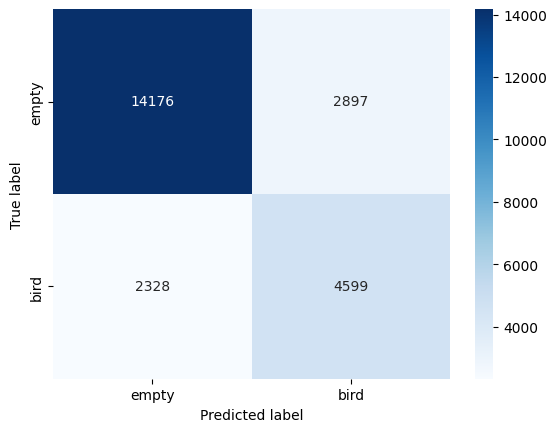

Fold 2
Accuracy: 0.824344 Avg loss: 0.935302 

              precision    recall  f1-score   support

       empty       0.85      0.92      0.88     22762
        bird       0.75      0.59      0.66      9238

    accuracy                           0.82     32000
   macro avg       0.80      0.76      0.77     32000
weighted avg       0.82      0.82      0.82     32000



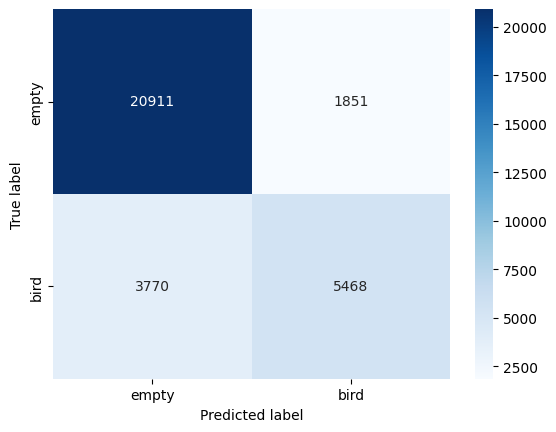

Estimated performance:
Accuracy: 0.838417 Avg loss: 0.725830 

              precision    recall  f1-score   support

       empty       0.87      0.91      0.89     17073
        bird       0.74      0.67      0.71      6927

    accuracy                           0.84     24000
   macro avg       0.81      0.79      0.80     24000
weighted avg       0.83      0.84      0.84     24000



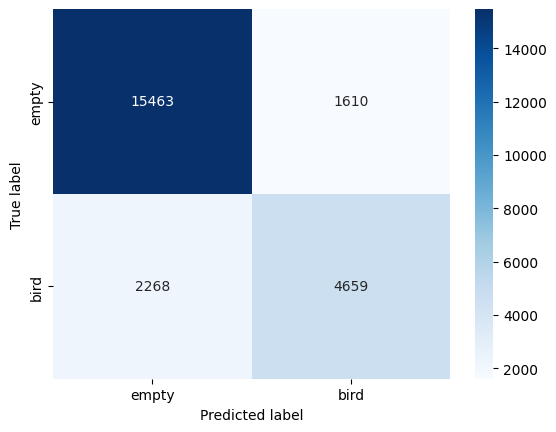

Fold 3
Accuracy: 0.737187 Avg loss: 4.553828 

              precision    recall  f1-score   support

       empty       0.73      0.99      0.84     22762
        bird       0.83      0.11      0.20      9238

    accuracy                           0.74     32000
   macro avg       0.78      0.55      0.52     32000
weighted avg       0.76      0.74      0.66     32000



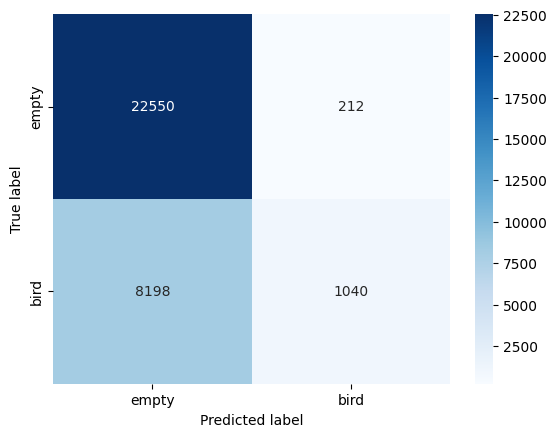

Estimated performance:
Accuracy: 0.797708 Avg loss: 2.158534 

              precision    recall  f1-score   support

       empty       0.81      0.94      0.87     17073
        bird       0.74      0.46      0.57      6927

    accuracy                           0.80     24000
   macro avg       0.78      0.70      0.72     24000
weighted avg       0.79      0.80      0.78     24000



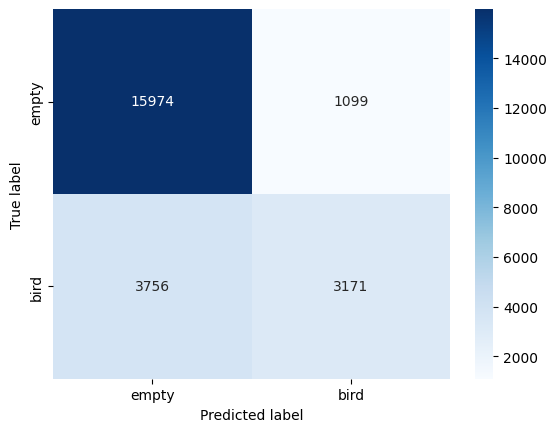

In [56]:
model = lambda _: nn.Sequential(
        nn.Linear(134, 128),
        nn.ReLU(),
        nn.Linear(128, 128),
        nn.ReLU(),
        nn.Linear(128, 2)
    )
eval(model, X_train_binary[:, indices], y_train_binary, ['empty', 'bird'], y_train_binary, 100, False, X_test_binary[:, indices], y_test_binary)